<a name='1'></a>
## Import Packages and load data

In [1]:
### -*- coding: utf-8 -*-
"""
Created on Mon May 24 13:26:13 2021

@author: kjsanche

Description: 
A function to load the 5 minute granules from MODIS channel 1 
(0.65 microns) and the contrail mask for ML with a CNN.

To do:
ASAP:
-create blacklist of images to exclude (if images are to big)
-separate testing data
-plot testing data vs mask



lower priority:
-optimize image shape by transforming back to original satellite swath projection
-save and set up to load data as tfrecord
-organize/markdown/comment code


Input:
Path   (string)

        
        
Output:
MODISCh1 (2D uint32)
MASK     (2D uint16)
"""


from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import struct
import os
import glob
import random
#from format_input import *
from UNET_Functions import unet_model, summary
from Sat_contrail_read import Extract_RawDef, extract_img, extract_mask, extract_imglist, get_model_memory_usage
import tensorflow as tf
import sys
sys.path.append('/home/kjsanche/Desktop/Projects/loss')
from loss_function import *
import tensorflow_addons as tfa

sys_details = tf.sysconfig.get_build_info()
print(sys_details)
cudnn_version = sys_details["cudnn_version"]
cuda_version = sys_details["cuda_version"]

print('cuda version: ', cuda_version)
print('cudNN version: ',cudnn_version)
print('TF version: ', tf.version.VERSION)


##############################################
# -Change loss function to something categorial
# -check  learning rate
##############################################



VALIDATION_SPLIT = 0.90
BATCH_SIZE = 1
EPOCHS = 1
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
IMG_W=1024
IMG_H=2048
N_CHANNELS = 7
TFrecord_path ='/home/kjsanche/Desktop/ExternalSSD/SatContrailData/TFrecords/'
#TFrecord_path = '/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/'
filenames=tf.io.gfile.glob([TFrecord_path + '*.tfrecords'])


random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

validation_steps = len(validation_filenames) #int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = len(training_filenames) #int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE

OrderedDict([('cpu_compiler', '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614583966145/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'), ('cuda_compute_capabilities', ['compute_35', 'compute_52', 'compute_60', 'compute_61', 'compute_70', 'compute_75']), ('cuda_version', '10.1'), ('cudnn_version', '7'), ('is_cuda_build', True), ('is_rocm_build', False)])
cuda version:  10.1
cudNN version:  7
TF version:  2.4.1


In [2]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'raw_label':tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
      'raw_image' : tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    height = 1024
    width = content['width']
    width = 1024*2
    depth = content['depth']
    depth = 7
    raw_label = content['raw_label']
    raw_image = content['raw_image']


    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float16)

    feature = tf.reshape(feature, shape=[height,width,depth])
    label = tf.io.parse_tensor(raw_label, out_type=tf.int8)
    label = tf.reshape(label, shape=[height,width])
    return (feature, label)

def get_batched_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(parse_tfr_element, num_parallel_calls=AUTO)

    dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
    dataset = dataset.prefetch(AUTO) #

    return dataset

def get_training_dataset(training_filenames):
    return get_batched_dataset(training_filenames)

def get_validation_dataset(training_filenames):
    return get_batched_dataset(validation_filenames)

def get_dataset_large(tfr_dir:str="/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/", pattern:str="*large_images.tfrecords"):
    files = glob.glob(tfr_dir+pattern, recursive=False)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)

    return dataset
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(i)
        #print(display_list[i].shape)
        if i == 0:
            plt.imshow(np.float32(display_list[i][:,:,0]-display_list[i][:,:,1]))
        else:
            plt.imshow(np.float32(1*display_list[i]))
        plt.axis('off')
    plt.show()

The below code cell uses a lot of memory and therefore should only be used for testing and not be used during training.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


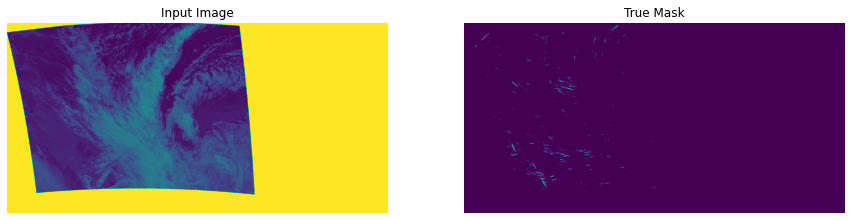

mem usage:  31458816


In [3]:
testdataset = get_dataset_large(tfr_dir = TFrecord_path, pattern = '*.tfrecords')
for image, mask in testdataset.take(3):
    sample_image, sample_mask = image, mask
    #print(mask.shape)
display([sample_image, sample_mask])
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

In [4]:

unet = unet_model((IMG_W, IMG_H, N_CHANNELS))
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=['accuracy'])
unet.summary(line_length = 130)
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

Model: "model"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
input_1 (InputLayer)                      [(None, 1024, 2048, 7)]      0                                                          
__________________________________________________________________________________________________________________________________
conv2d (Conv2D)                           (None, 1024, 2048, 32)       2048            input_1[0][0]                              
__________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                         (None, 1024, 2048, 32)       9248            conv2d[0][0]                               
____________________________________________________________________

In [5]:
print(get_model_memory_usage(BATCH_SIZE, unet))


print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))
training_data = get_training_dataset(training_filenames)
print(training_data)
model_history = unet.fit(training_data, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)

3.876
mem usage:  66031104
<PrefetchDataset shapes: ((1, 1024, 2048, 7), (1, 1024, 2048)), types: (tf.float16, tf.int8)>


ValueError: in user code:

    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/keras_utils.py:61 call  *
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/losses/focal_loss.py:121 sigmoid_focal_crossentropy  *
        ce = K.binary_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4994 binary_crossentropy
        bce = target * math_ops.log(output + epsilon())
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1496 _mul_dispatch
        return multiply(x, y, name=name)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:518 multiply
        return gen_math_ops.mul(x, y, name)
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:6077 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/kjsanche/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1024 and 2048 for '{{node mul}} = Mul[T=DT_FLOAT](Cast, Log)' with input shapes: [1,1024,2048], [1,1024,2048,8].


In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    #print(pred_mask.shape)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image[tf.newaxis,:,:,:])
            print(pred_mask.shape)
            test=  np.squeeze(pred_mask[:,:,:,-1])
            print(test.shape)
            #display([image, mask, test])
            display([image, mask, create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
testdataset = get_dataset_large(tfr_dir = TFrecord_path, pattern = '*.tfrecords')
print(testdataset)
#show_predictions(testdataset, 10)

#####################change display to show 11microns -12 microns or whatever it should be

In [ ]:
pr_mask = unet.predict(image[tf.newaxis,:,:,:])
plt.imshow(
    pr_mask[0]
)